# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# For instance, you will need the smdebug package
!pip install smdebug
!pip install sagemaker boto3

  Preparing metadata (setup.py) ... done
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl size=6415 sha256=7cbe35ea1b6884e9d231acb81e7be2985b78ef927b549d3ae51fd247c0c1fd2d
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/6c/d4/b3/f7bd451cdb774b086ee5c4791eff9a667fb197759f2f691f66
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [79]:
# Import SageMaker libraries
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.tuner import HyperparameterTuningJobAnalytics

from smdebug.trials import create_trial
# Import AWS libraries
import boto3

# Import Data processing libraries
import io
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image

import IPython
import matplotlib.pyplot as plt
import base64
import json
from torchvision import transforms

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
# Command to download and unzip data
!wget --no-check-certificate https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvf cifar-100-python.tar.gz

--2024-12-15 08:52:09--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  91.0MB/s    in 1.8s    

2024-12-15 08:52:11 (91.0 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [4]:
# Transfer Cifer Train data to image
os.makedirs('./train', exist_ok=True)
with open('./cifar-100-python/train', 'rb') as raw_data:
    train_dict = pickle.load(raw_data, encoding='bytes')
    images= train_dict[b'data']
    filenames = train_dict[b'filenames']
    labels = train_dict[b'fine_labels']
    for index, img in enumerate(images):
        img = Image.fromarray(img.reshape(3, 32, 32).transpose(1, 2, 0))
        img.save(os.path.join('./train', filenames[index].decode('utf-8')))

In [5]:
# Transfer Cifer Test data to image
os.makedirs('./test', exist_ok=True)
with open('./cifar-100-python/test', 'rb') as raw_data:
    test_dict = pickle.load(raw_data, encoding='bytes')
    images= test_dict[b'data']
    filenames = test_dict[b'filenames']
    labels = test_dict[b'fine_labels']
    for index, img in enumerate(images):
        img = Image.fromarray(img.reshape(3, 32, 32).transpose(1, 2, 0))
        img.save(os.path.join('./test', filenames[index].decode('utf-8')))

In [6]:
# get role region and bucket info from sagemaker and boto3 
session = sagemaker.Session()
role = get_execution_role()
print(role)
region = boto3.Session().region_name
print(region)
default_bucket = session.default_bucket()
print(default_bucket)

arn:aws:iam::193237859491:role/service-role/AmazonSageMaker-ExecutionRole-20241215T173721
us-east-1
sagemaker-us-east-1-193237859491


In [7]:
# calculate the image number under the train and test folder
!echo train image
!ls -1 ./train | wc -l
!echo test image
!ls -1 ./test | wc -l

train image
49999
test image
9999


In [ ]:
# sync file to s3
!aws s3 sync ./train s3://{default_bucket}/train --exclude "*" --include "*.png" --quiet
!aws s3 sync ./test s3://{default_bucket}/test --exclude "*" --include "*.png" --quiet

In [9]:
# check the file number in each s3 folder
!echo train image in s3
!aws s3 ls s3://$default_bucket/train/ --recursive --human-readable --summarize | grep "Total Objects"
!echo test image in s3
!aws s3 ls s3://$default_bucket/test/ --recursive --human-readable --summarize | grep "Total Objects"

train image in s3
Total Objects: 49999
test image in s3
Total Objects: 9999


In [10]:
# create a train label file and upload to s3
labels = train_dict[b'fine_labels']
filenames = train_dict[b'filenames']
with open('train.txt', 'w') as label_file:
    for filename, label in zip(filenames, labels):
        label_file.write(f"{filename.decode('utf-8')},{label}\n")
!aws s3 cp ./train.txt s3://$default_bucket/train.txt

upload: ./train.txt to s3://sagemaker-us-east-1-193237859491/train.txt


In [11]:
# create a test label file and upload to s3
labels = test_dict[b'fine_labels']
filenames = test_dict[b'filenames']
with open('test.txt', 'w') as label_file:
    for filename, label in zip(filenames, labels):
        label_file.write(f"{filename.decode('utf-8')},{label}\n")
!aws s3 cp ./test.txt s3://$default_bucket/test.txt

upload: ./test.txt to s3://sagemaker-us-east-1-193237859491/test.txt


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [12]:
#Declare HP ranges, metrics.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": CategoricalParameter([10, 20, 30, 40, 50,60,70,80])
}
metrix=[{'Name': 'validation_accuracy', 'Regex': 'Validation Accuracy: (\S+)'}]

In [15]:
#Create estimators

estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    output_path=f"s3://{default_bucket}/output"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name='validation_accuracy',
    metric_definitions=metrix,
    objective_type='Maximize',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=1
)
inputs = {
    'train': f's3://{default_bucket}/train/',
    'trainlabel': f's3://{default_bucket}/train.txt',
    'test': f's3://{default_bucket}/test/',
    'testlabel': f's3://{default_bucket}/test.txt'
}

In [16]:
# Fit HP Tuner
tuner.fit(inputs)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
# list tunning result
tuning_job_name = tuner.latest_tuning_job.name
tuning_job = HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
tuning_job

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""256""","""40""",0.012483,pytorch-training-241215-0920-010-fdb39bbf,Completed,41.034100,2024-12-15 10:46:26+00:00,2024-12-15 10:51:10+00:00,284.0
1,"""128""","""70""",0.017483,pytorch-training-241215-0920-009-8b627de7,Completed,43.454300,2024-12-15 10:36:05+00:00,2024-12-15 10:45:00+00:00,535.0
2,"""64""","""40""",0.012967,pytorch-training-241215-0920-008-cb72da9c,Completed,42.774300,2024-12-15 10:26:54+00:00,2024-12-15 10:35:15+00:00,501.0
3,"""512""","""30""",0.028807,pytorch-training-241215-0920-007-3d756edc,Completed,39.633999,2024-12-15 10:22:19+00:00,2024-12-15 10:25:53+00:00,214.0
4,"""64""","""10""",0.100000,pytorch-training-241215-0920-006-bc7b5a47,Completed,28.912901,2024-12-15 10:19:01+00:00,2024-12-15 10:21:56+00:00,175.0
5,"""128""","""70""",0.039635,pytorch-training-241215-0920-005-ddbbe281,Completed,41.494099,2024-12-15 10:08:33+00:00,2024-12-15 10:17:28+00:00,535.0
6,"""256""","""40""",0.030390,pytorch-training-241215-0920-004-86c7af26,Completed,41.544201,2024-12-15 10:03:05+00:00,2024-12-15 10:07:45+00:00,280.0
7,"""512""","""80""",0.001586,pytorch-training-241215-0920-003-abf2d185,Completed,39.393902,2024-12-15 09:54:27+00:00,2024-12-15 10:02:17+00:00,470.0
8,"""512""","""20""",0.014155,pytorch-training-241215-0920-002-b8793217,Completed,41.394100,2024-12-15 09:51:06+00:00,2024-12-15 09:53:50+00:00,164.0
9,"""32""","""70""",0.089748,pytorch-training-241215-0920-001-86db0daf,Completed,23.382299,2024-12-15 09:22:33+00:00,2024-12-15 09:49:18+00:00,1605.0


In [23]:
# Get the best estimators and the best HPs
best_estimator=tuner.best_estimator()
best_hyperparameters_raw=best_estimator.hyperparameters()
print(best_hyperparameters_raw)


2024-12-15 10:46:24 Starting - Starting the training job
2024-12-15 10:46:24 Pending - Found matching resource for reuse
2024-12-15 10:46:24 Downloading - Downloading the training image
2024-12-15 10:46:24 Training - Training image download completed. Training in progress.
2024-12-15 10:46:24 Uploading - Uploading generated training model
2024-12-15 10:46:24 Completed - Resource reused by training job: pytorch-training-241215-0920-010-fdb39bbf
{'_tuning_objective_metric': '"validation_accuracy"', 'batch_size': '"128"', 'epochs': '"70"', 'learning_rate': '0.017483127170473314', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2024-12-15-09-20-22-643"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-193237859491/pytorch-training-2024-12-15-09-20-22-643/source/sourcedir.ta

In [24]:
# Format the HP
best_hyperparameters = {
    "learning_rate": float(best_hyperparameters_raw['learning_rate'].strip('"')),
    "batch_size": int(best_hyperparameters_raw['batch_size'].strip('"')),
    "epochs": int(best_hyperparameters_raw['epochs'].strip('"'))
}
print(best_hyperparameters)

{'learning_rate': 0.017483127170473314, 'batch_size': 128, 'epochs': 70}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [25]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, rule_configs,ProfilerRule
from sagemaker.debugger import DebuggerHookConfig,ProfilerConfig, Profiler,FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.StepOutlier()),
    ProfilerRule.sagemaker(rule_configs.GPUMemoryIncrease()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "50", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [26]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    hyperparameters=best_hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
    output_path=f's3://{default_bucket}/output'
)
estimator.fit(inputs)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-12-15-11-13-34-799


2024-12-15 11:13:35 Starting - Starting the training job
2024-12-15 11:13:35 Pending - Training job waiting for capacity...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
StepOutlier: InProgress
GPUMemoryIncrease: InProgress
ProfilerReport: InProgress
...
2024-12-15 11:14:28 Pending - Preparing the instances for training...
2024-12-15 11:15:09 Downloading - Downloading input data......
2024-12-15 11:16:09 Downloading - Downloading the training image.........
2024-12-15 11:17:29 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-15 11:17:49,154 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-15 11:17:49,186 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-15 11:17:49,189 sagemaker_pytorch_co

In [28]:
# Download debug data
debug_output_path = estimator.output_path +"/"+ estimator.latest_training_job.job_name + "/debug-output/"
print(debug_output_path)
! aws s3 cp {debug_output_path} ./debug-output/ --recursive --quiet

s3://sagemaker-us-east-1-193237859491/output/pytorch-training-2024-12-15-11-13-34-799/debug-output/


[2024-12-15 11:48:39.741 default:145 INFO local_trial.py:35] Loading trial  at path ./debug-output/
[2024-12-15 11:48:39.830 default:145 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-12-15 11:48:40.834 default:145 INFO trial.py:210] Loaded all steps


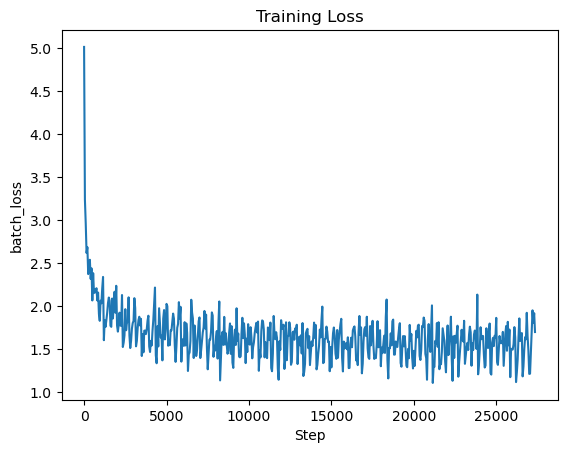

<Figure size 640x480 with 0 Axes>

In [33]:
# Display the debugger output
local_path = "./debug-output/"
trial = create_trial(local_path)
batch_loss_tensor = trial.tensor('batch_loss')
steps = batch_loss_tensor.steps()
values = [batch_loss_tensor.value(step) for step in steps]
plt.plot(steps, values)
plt.xlabel('Step')
plt.ylabel('batch_loss')
plt.title('Training Loss')
plt.show()
plt.savefig("batch_loss.png", format="png", dpi=300)
#print(steps)
#print(values)
#print(trial.tensor_names())

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [36]:
# Display the profiler output

rule_output_path = estimator.output_path +"/"+ estimator.latest_training_job.job_name + "/rule-output"
print(rule_output_path)
! aws s3 cp {rule_output_path} ./ --recursive --quiet

profiler_report_name = None
for rule in estimator.latest_training_job.rule_job_summary():
    if "Profiler" in rule.get("RuleConfigurationName", ""):
        profiler_report_name = rule["RuleConfigurationName"]
        break
print(profiler_report_name)


ProfilerReport


In [37]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [85]:
# Deploy model to an endpoint
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(
    model_data=estimator.model_data,
    role=role,
    entry_point='inference.py',
    framework_version='1.5.0',
    py_version='py3'
)

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.p3.2xlarge'
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-193237859491/output/pytorch-training-2024-12-15-11-13-34-799/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-193237859491/pytorch-inference-2024-12-15-13-37-05-389/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-12-15-13-37-13-231
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-12-15-13-37-13-953
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-12-15-13-37-13-953


----------!

In [88]:
# Run an prediction on the endpoint
sagemaker_runtime = boto3.client('sagemaker-runtime')
s3_client = boto3.client('s3')
image_data = (s3_client.get_object(Bucket=default_bucket, Key="test/bike_s_000457.png"))['Body'].read()

payload = {
    "image": base64.b64encode(image_data).decode('utf-8')
}
payload_json = json.dumps(payload)
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType='application/json',
    Body=payload_json
)
response_body = response['Body'].read().decode('utf-8')

print(f"The prediction of this image is {response_body}")
image = Image.open(io.BytesIO(image_data)).convert('RGB')

The prediction of this image is {"prediction": "bicycle", "prediction_raw": [8]}


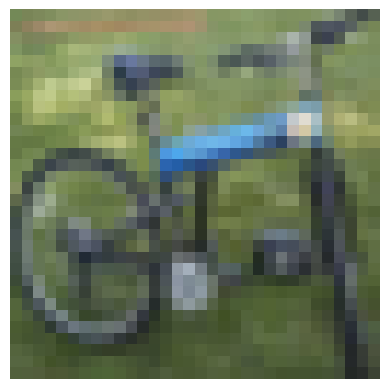

In [89]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [84]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-12-15-13-30-09-240
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-12-15-13-30-09-240
